In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sqlite3

#Data is from 000webhost leakage

In [2]:
con = sqlite3.connect(r"/Users/ilkaymueller/Documents/GitHub/Machine Learning projects/Password strength prediction/password_data.sqlite")

In [3]:
data = pd.read_sql_query("SELECT * FROM Users", con)

In [4]:
data.shape

(100000, 3)

# Cleaning the data

In [5]:
data.head()

,index,password,strength
0,0,zxe870819,1
1,1,xw46454nr23l,1
2,2,soporte13,1
3,3,accounts6000webhost.com,2
4,4,c443balg,1


0 is the weakest, 1 is the medium strength, 2 shows a strong password. I will clean the index part.

In [6]:
data.drop(['index'], axis = 1, inplace = True)

In [7]:
data.head()

,password,strength
0,zxe870819,1
1,xw46454nr23l,1
2,soporte13,1
3,accounts6000webhost.com,2
4,c443balg,1


In [8]:
data.duplicated().sum()

0

no duplicates

In [9]:
data.isnull().any()

password    False
strength    False
dtype: bool

In [10]:
data.isnull().sum()

password    0
strength    0
dtype: int64

There is no missing value in the dataset. I will check the data types.

# Exploring the data for semantic analysis

In [11]:
data.dtypes

password    object
strength     int64
dtype: object

In [12]:
data['strength'].unique()

array([1, 2, 0])

Cell 13 shows that there is no irrelevant value in the strength column.

In [13]:
data['password']

0                      zxe870819
1                   xw46454nr23l
2                      soporte13
3        accounts6000webhost.com
4                       c443balg
                  ...           
99995                 obejofi215
99996                 fmiopvxb64
99997                  czvrbun38
99998                  mymyxe430
99999                glqjhkxb467
Name: password, Length: 100000, dtype: object

Lets see how many passwords consist of numbers only :

In [14]:
a = data[data['password'].str.isnumeric()]
a

,password,strength
12280,943801,0
14992,12345,0
20958,147856,0
21671,140290,0
23269,123987,0
28569,1233214,0
31329,0159456,0
32574,363761,0
37855,4524344,0
43648,5521597,0


In [15]:
a.shape

(26, 2)

26 passowrds in the dataset consist of only numbers which all has 0 strength, basically weak.

In the same way, I will check passwords with letters only.

In [16]:
data[data['password'].str.isalpha()].shape

(50, 2)

50 passwords in the data set consist of letters only.

Lets see how many passwords are with upper characters.

In [17]:
data[data['password'].str.isupper()].shape

(1506, 2)

1506 passwords out of 100K is with upper characters. (still can include numbers). So I will check letters+numbers (I mean without special characters).

In [18]:
data[data['password'].str.isalnum()].shape

(97203, 2)

97203 out of 100000, means many people created passwords with numbers and letters only. 

I am going to check the punctuations.

In [19]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
def find_semantics(row):
    for char in row:
        if char in string.punctuation:
            return 1
        else:
            pass

In [21]:
data['password'].apply(find_semantics) ==1 

0        False
1        False
2        False
3         True
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Name: password, Length: 100000, dtype: bool

In [22]:
data[data['password'].apply(find_semantics) ==1]

,password,strength
3,accounts6000webhost.com,2
68,12463773800+,1
98,p.r.c.d.g.,1
145,cita-cita,1
180,karolina.susnina0U,2
...,...,...
99748,maiselis.com,1
99845,hosting4meze!@#,2
99954,semista_bakung15,2
99980,halflife2010!LEB,2


2663 accounts used semantics in their passwords

# Feature Engineering 

The strength of password depends on: its length and frequencies of : uppercase, lowercase, numeric and speacial characters. 

In [23]:
# I am gonna add length column for password length.

data['length'] = data['password'].str.len()

In [24]:
data.head()

,password,strength,length
0,zxe870819,1,9
1,xw46454nr23l,1,12
2,soporte13,1,9
3,accounts6000webhost.com,2,23
4,c443balg,1,8


Lowercase

In [25]:
password = 'IlkayMueller007'

In [26]:
[char for char in password if char.islower()]

['l', 'k', 'a', 'y', 'u', 'e', 'l', 'l', 'e', 'r']

In [27]:
len([char for char in password if char.islower()])

10

In [28]:
#Normalizing the length for outliers
len([char for char in password if char.islower()])/len(password)

0.6666666666666666

In [29]:
def lowercase_freq(row):
    return len([char for char in row if char.islower()])/len(row)

Same for upper

In [30]:
def uppercase_freq(row):
    return len([char for char in row if char.isupper()])/len(row)

Similar for numeric

In [31]:
def numeric_freq(row):
    return len([char for char in row if char.isdigit()])/len(row)

Adding them as columns:

In [32]:
data['lowercase_freq'] = np.round(data['password'].apply(lowercase_freq),3)
data['uppercase_freq'] = np.round(data['password'].apply(uppercase_freq),3)
data['numeric_freq'] = np.round(data['password'].apply(numeric_freq),3)

In [33]:
data.head()

,password,strength,length,lowercase_freq,uppercase_freq,numeric_freq
0,zxe870819,1,9,0.333,0.0,0.667
1,xw46454nr23l,1,12,0.417,0.0,0.583
2,soporte13,1,9,0.778,0.0,0.222
3,accounts6000webhost.com,2,23,0.783,0.0,0.174
4,c443balg,1,8,0.625,0.0,0.375


Only Special characters left, I will check their frequencies.

In [34]:
def specialchar_freq(row):
    special_char = []
    for char in row:
        if not char.isalpha() and not char.isdigit():
            special_char.append(char)
    return len(special_char)

In [35]:
data['specialchar_freq'] = (np.round(data['password'].apply(specialchar_freq), 3 ))/ data["length"]

In [36]:
data.head()

,password,strength,length,lowercase_freq,uppercase_freq,numeric_freq,specialchar_freq
0,zxe870819,1,9,0.333,0.0,0.667,0.000000
1,xw46454nr23l,1,12,0.417,0.0,0.583,0.000000
2,soporte13,1,9,0.778,0.0,0.222,0.000000
3,accounts6000webhost.com,2,23,0.783,0.0,0.174,0.043478
4,c443balg,1,8,0.625,0.0,0.375,0.000000


# Descriptive 

In [39]:
data[['length', 'strength']].groupby(['strength']).agg(['min', 'max','mean', 'median'])

length                       
            min  max       mean median
strength                              
0             1    7   6.550947    7.0
1             8   13   9.611074    9.0
2            14  220  15.953421   16.0

Looks like, longer passwords are stronger. I will check for others with sns.

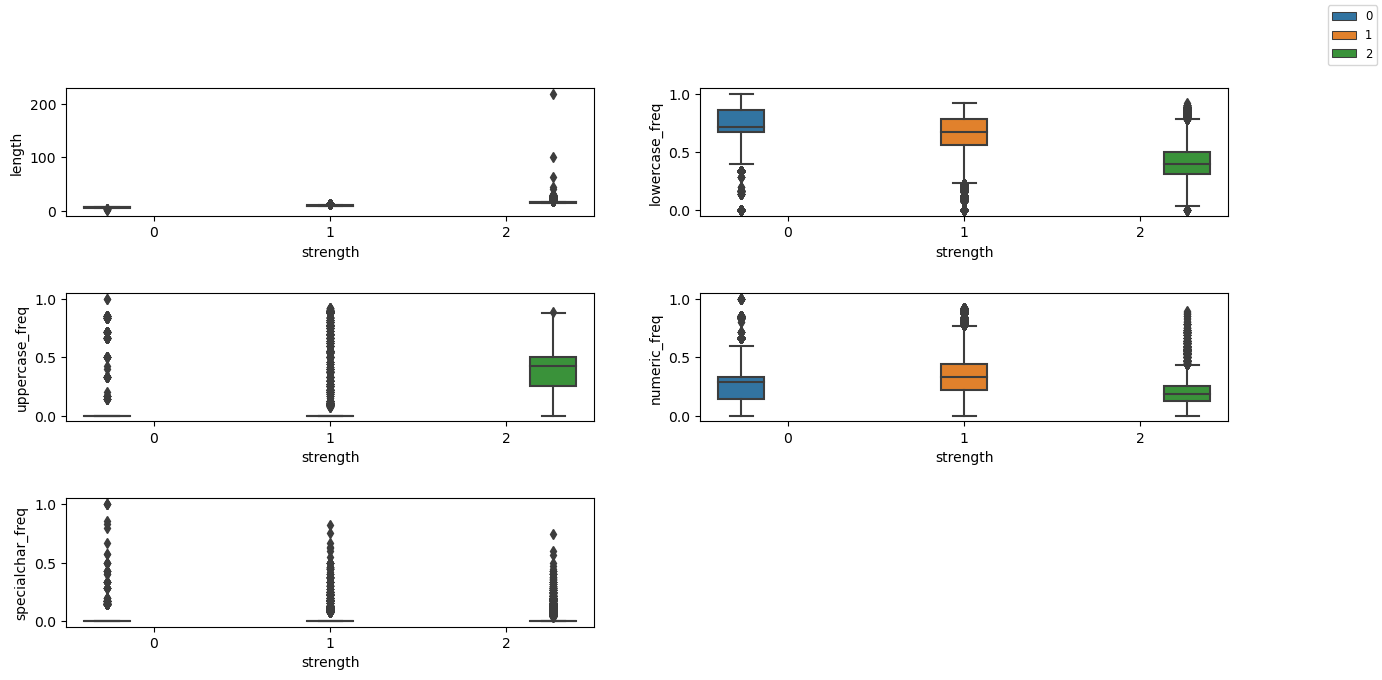

In [54]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 7))

sns.boxplot(x="strength", y="length", hue="strength", ax=ax1, data=data)
sns.boxplot(x="strength", y="lowercase_freq", hue="strength", ax=ax2, data=data)
sns.boxplot(x="strength", y="uppercase_freq", hue="strength", ax=ax3, data=data)
sns.boxplot(x="strength", y="numeric_freq", hue="strength", ax=ax4, data=data)
sns.boxplot(x="strength", y="specialchar_freq", hue="strength", ax=ax5, data=data)

# Hiding the empty subplot
fig.delaxes(ax6)

# I created a custom legend outside of the subplots for all of them (because I used the same parameter for hue)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize='small')

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()  #I removed individual legends, bc they were covering my subplots-added above a common one


plt.subplots_adjust(hspace=0.6)


plt.show()


# ADD MORE here
Looks like the long password, frequent uppercase usage has positive effect on strength. Lowercase freq has probably sth to do with length. Numeric char freq doesn't seem to effect too much. 

# Feature Importances

In [55]:
def get_dist(data , feature):
    
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    
    sns.violinplot(x='strength' , y=feature , data=data )
    
    plt.subplot(1,2,2)
    
    sns.distplot(data[data['strength']==0][feature] , color="red" , label="0" , hist=False)
    sns.distplot(data[data['strength']==1][feature], color="blue", label="1", hist=False)
    sns.distplot(data[data['strength']==2][feature], color="orange", label="2", hist=False)
    plt.legend()
    plt.show()

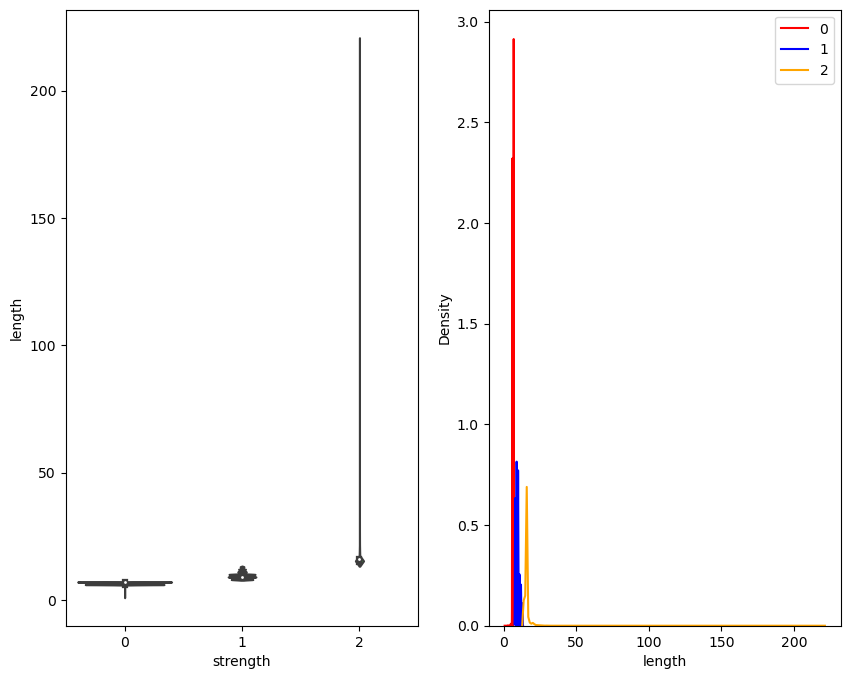

In [56]:
get_dist(data , "length")

Of course it makes sense to have passwords usually having up to 20-30 characters from what I see from the second graph, didnt remove the outliers, led to larger graph but less detail. Many people are using short and not strong passwords, as seen in the density. Still, apperently, longer passwords are more likely to be strong from the first and second plot. 

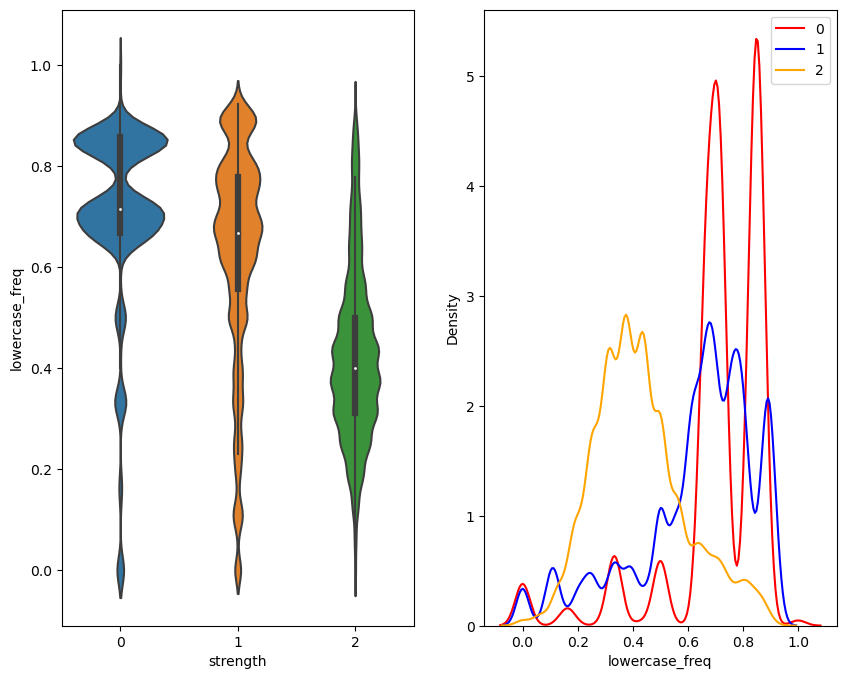

In [57]:
get_dist(data , 'lowercase_freq')

An interesting feature shows that frequent lowercase usage has negative effect on password strength. Still there are some overlapping areas. Looks like, if the lowercase usage is more than 60% of the characters in the password, that password is likely to be weak while using it as 30%-50% of the password can be ideal. 

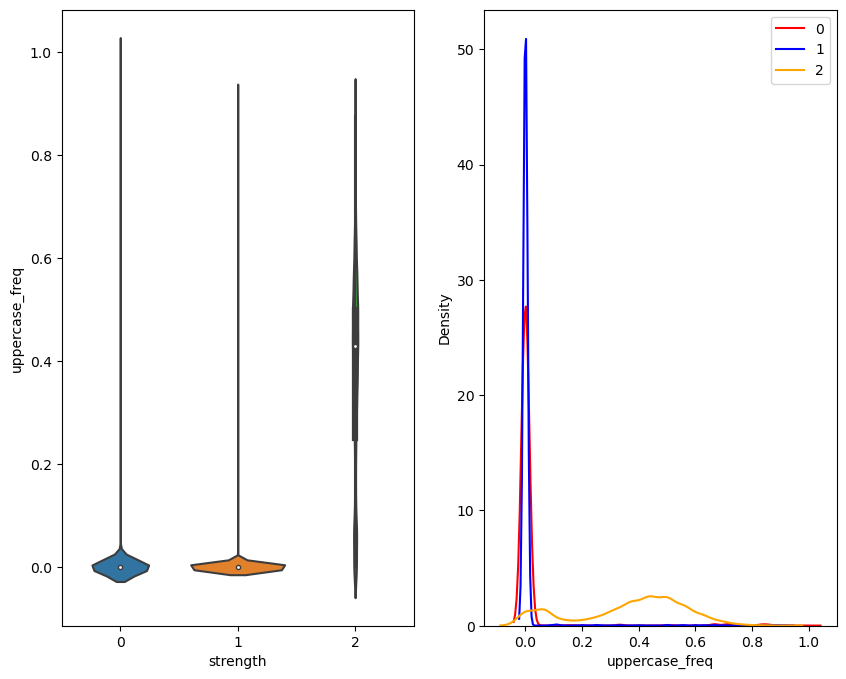

In [58]:
get_dist(data , 'uppercase_freq')

Having an upper case is njot affecting the strength drastically though it definitely has a slight positive effect. Also looks like it is not people's favorite, not mine either :) 

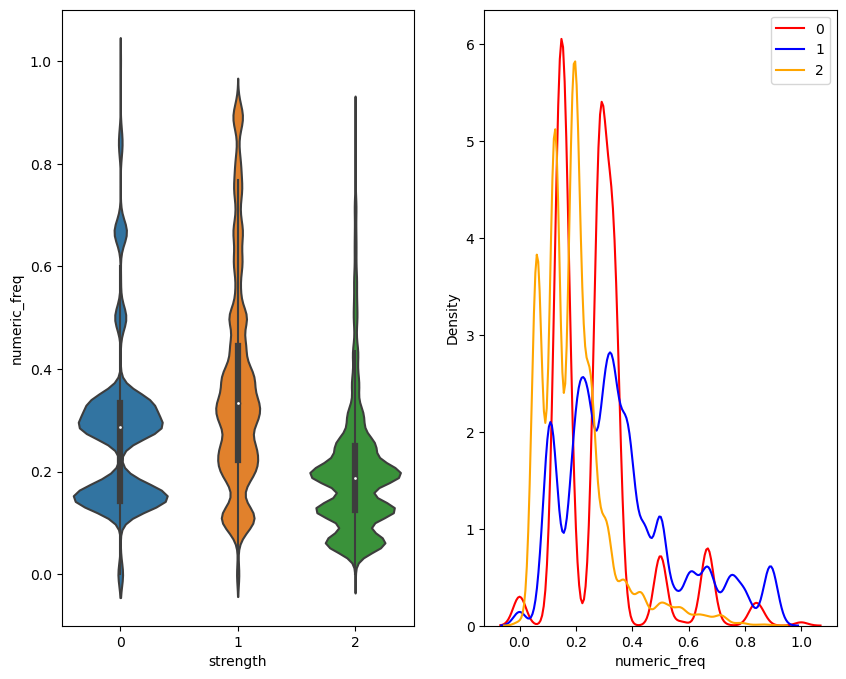

In [60]:
get_dist(data , 'numeric_freq')

Surprisingly, numeric feature doesnt seem to affect the strength as it has similar behaviour for weak and strong.

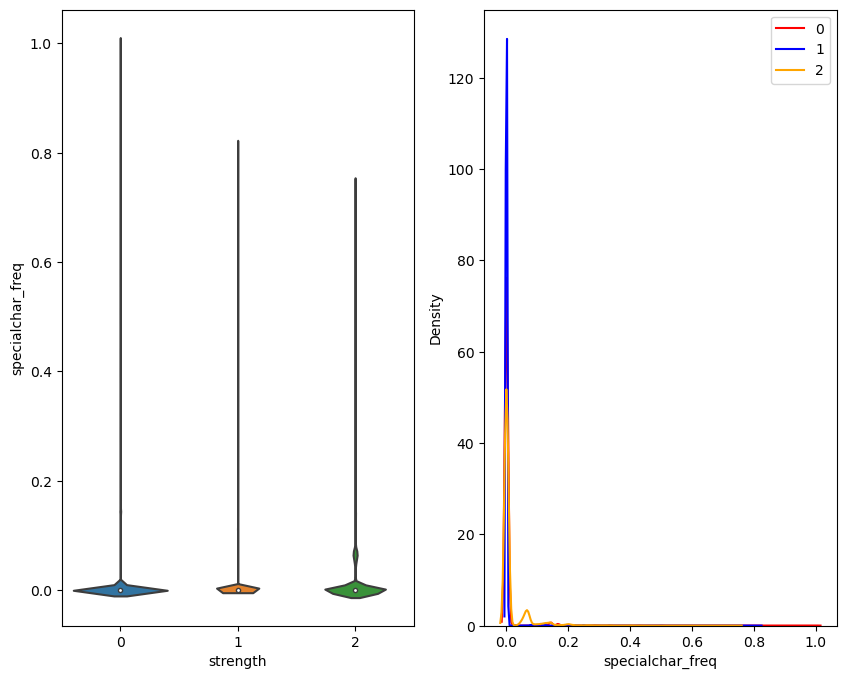

In [61]:
get_dist(data , 'specialchar_freq')

Again surprising result for the special characters. I personally would expect that the higher the usage the higher the strength, but this isn't the case obviously. The first graph has similar shapes and second graph has quite overlapping view means it doesn't affect much. Overall for features, we can conclude that length and lowercase usage are significant features.

# TF IDF